In [ ]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

In [ ]:
def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

In [ ]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

In [ ]:
# helper function to load images
load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs 
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (400, 400))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

In [ ]:
from pathlib import Path

# s = set()
files = []
path = Path('/content/Temp/image')
set = ()
for file in path.iterdir():
    file = str(file)
    file2 = str(file)
    file2 = file2.replace('image','try-on')
    files.append([file,file2])

print(files)


[['/content/Temp/image/014201_0.jpg', '/content/Temp/try-on/014201_0.jpg'], ['/content/Temp/image/005031_0.jpg', '/content/Temp/try-on/005031_0.jpg'], ['/content/Temp/image/007672_0.jpg', '/content/Temp/try-on/007672_0.jpg'], ['/content/Temp/image/004785_0.jpg', '/content/Temp/try-on/004785_0.jpg'], ['/content/Temp/image/017779_0.jpg', '/content/Temp/try-on/017779_0.jpg'], ['/content/Temp/image/010937_0.jpg', '/content/Temp/try-on/010937_0.jpg'], ['/content/Temp/image/017370_0.jpg', '/content/Temp/try-on/017370_0.jpg'], ['/content/Temp/image/012545_0.jpg', '/content/Temp/try-on/012545_0.jpg'], ['/content/Temp/image/017358_0.jpg', '/content/Temp/try-on/017358_0.jpg'], ['/content/Temp/image/004115_0.jpg', '/content/Temp/try-on/004115_0.jpg'], ['/content/Temp/image/013518_0.jpg', '/content/Temp/try-on/013518_0.jpg'], ['/content/Temp/image/017536_0.jpg', '/content/Temp/try-on/017536_0.jpg'], ['/content/Temp/image/018167_0.jpg', '/content/Temp/try-on/018167_0.jpg'], ['/content/Temp/image/00

In [ ]:
lst = {}

for i,x in enumerate(files):
  _img1 = tensorify(load_images(x[0]))
  _img2 = tensorify(load_images(x[1]))
  true_vs_false = ssim(_img1, _img2, val_range=255)
  lst.update({i:true_vs_false.numpy()})

Highest SSIM Score : 0.9344335794448853
SSIM Score of Top 20 images
SSIM Score of image 1 : 0.9344335794448853 


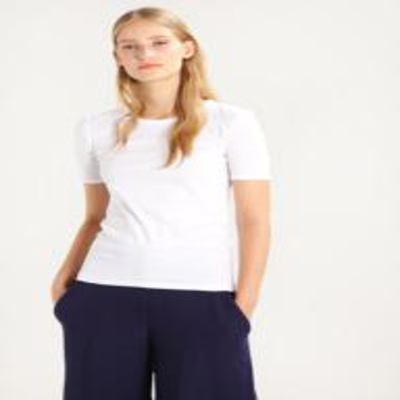

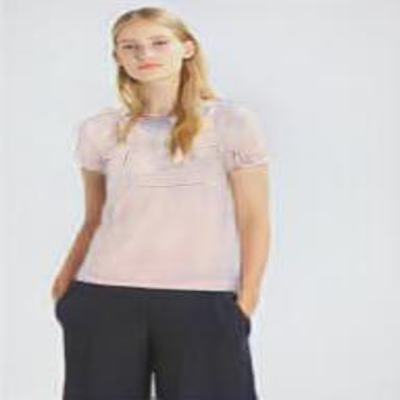

-----------------------------------------------------------------------

SSIM Score of image 2 : 0.9340342879295349 


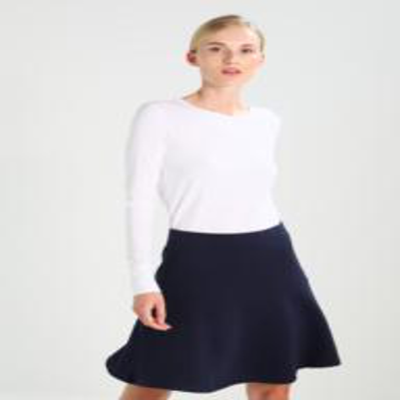

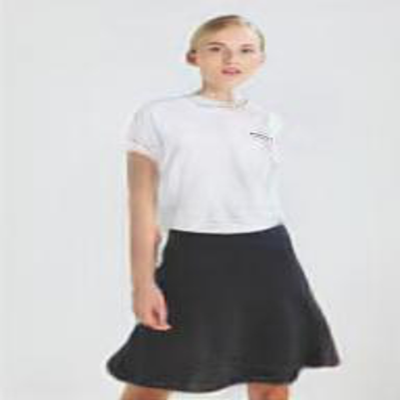

-----------------------------------------------------------------------

SSIM Score of image 3 : 0.9330283403396606 


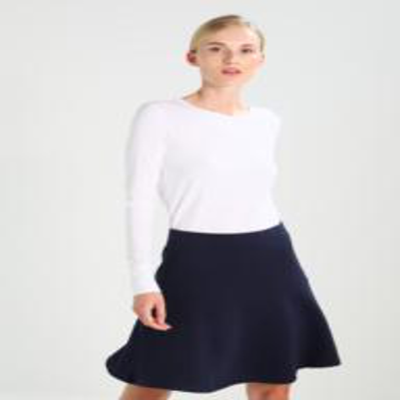

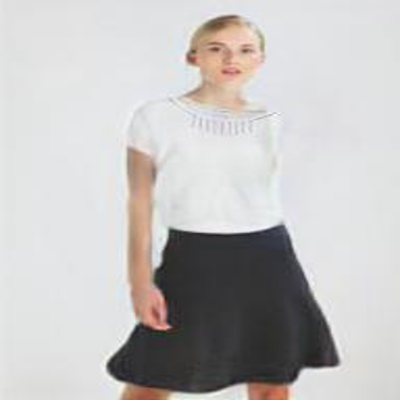

-----------------------------------------------------------------------

SSIM Score of image 4 : 0.9306389689445496 


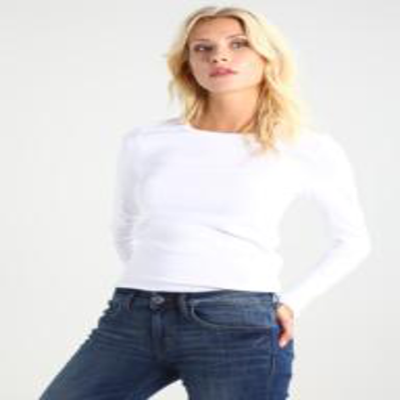

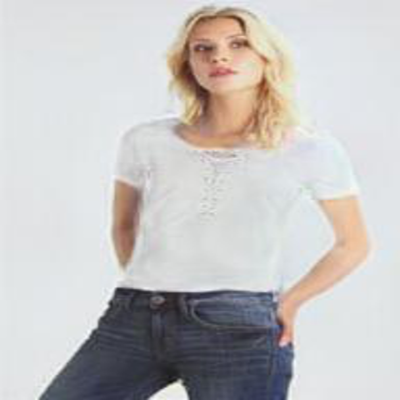

-----------------------------------------------------------------------

SSIM Score of image 5 : 0.9295370578765869 


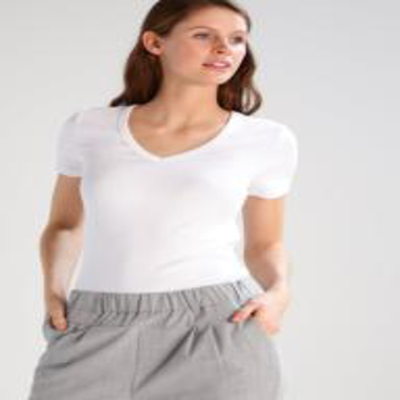

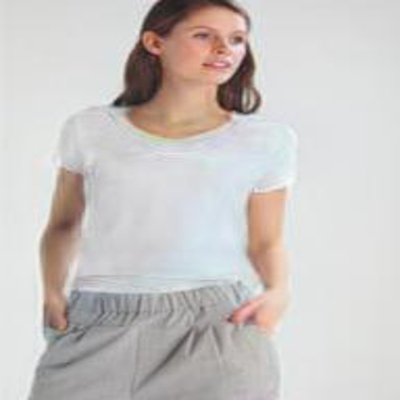

-----------------------------------------------------------------------

SSIM Score of image 6 : 0.9276516437530518 


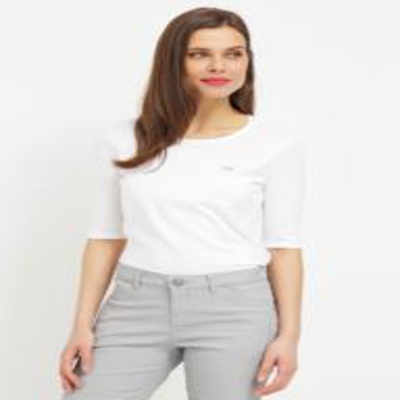

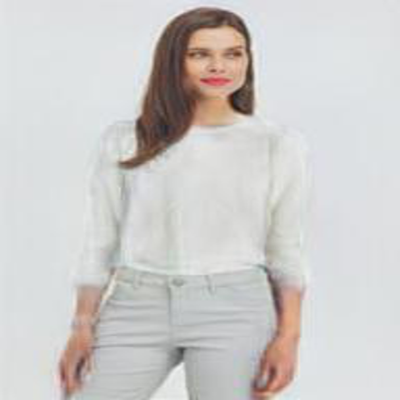

-----------------------------------------------------------------------

SSIM Score of image 7 : 0.9262228608131409 


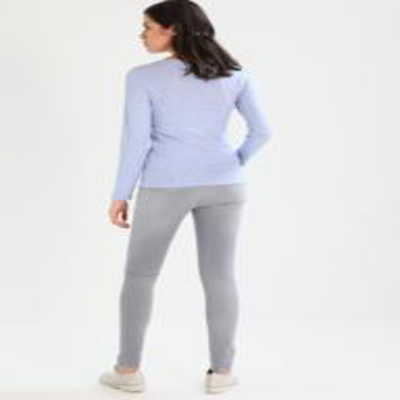

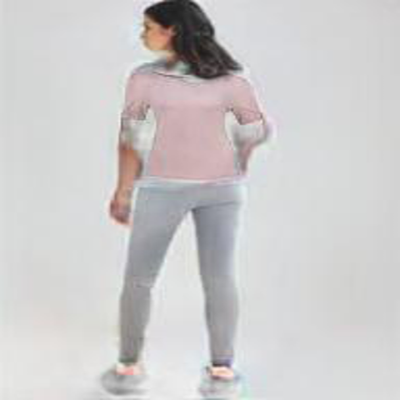

-----------------------------------------------------------------------

SSIM Score of image 8 : 0.9255150556564331 


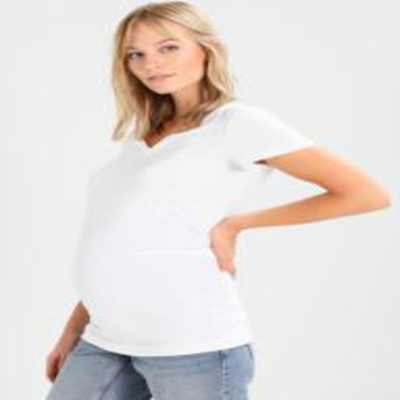

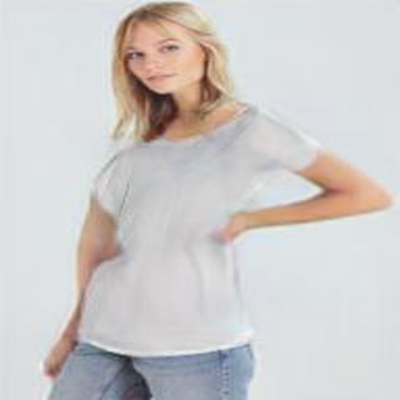

-----------------------------------------------------------------------

SSIM Score of image 9 : 0.9230984449386597 


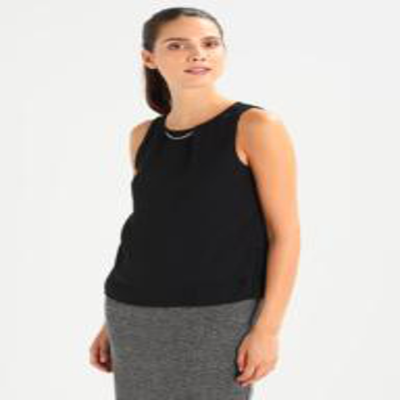

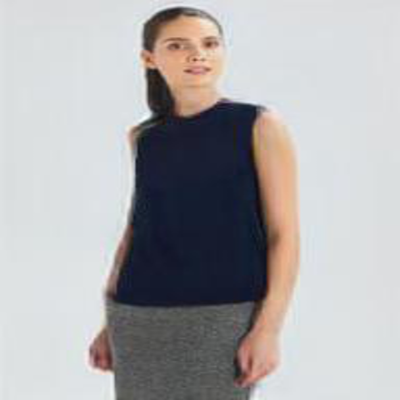

-----------------------------------------------------------------------

SSIM Score of image 10 : 0.9223946928977966 


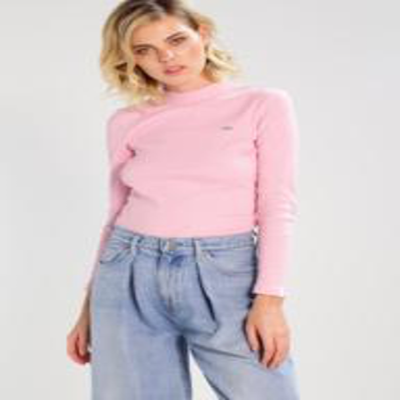

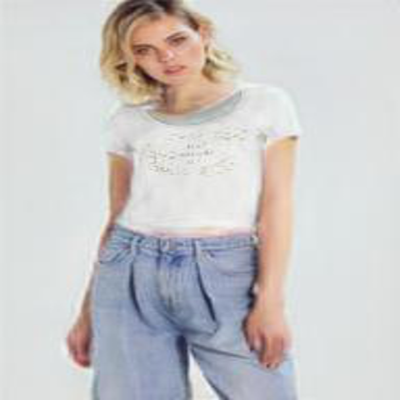

-----------------------------------------------------------------------

SSIM Score of image 11 : 0.9212684035301208 


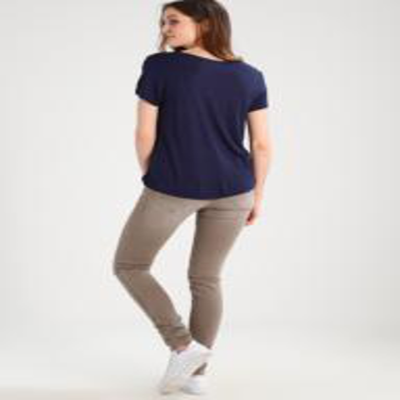

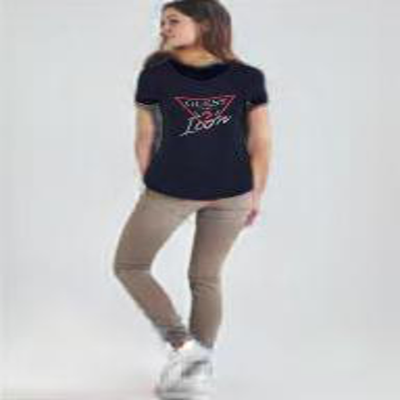

-----------------------------------------------------------------------

SSIM Score of image 12 : 0.9208173751831055 


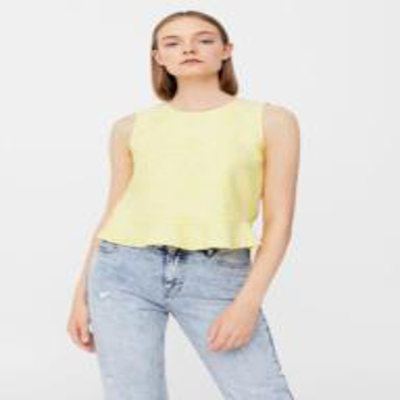

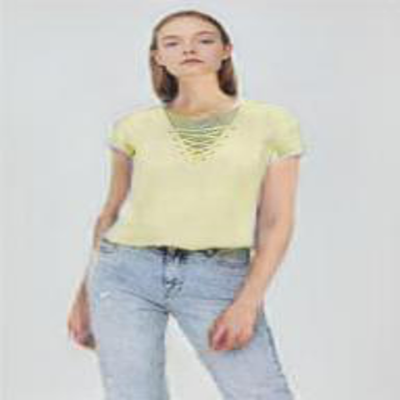

-----------------------------------------------------------------------

SSIM Score of image 13 : 0.9205513596534729 


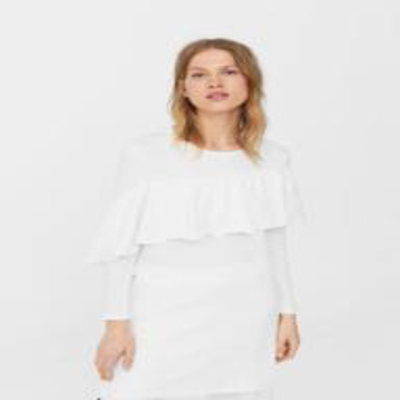

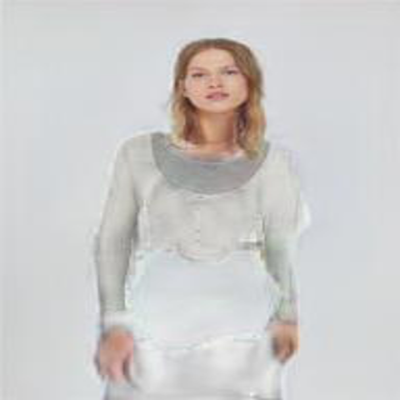

-----------------------------------------------------------------------

SSIM Score of image 14 : 0.920292854309082 


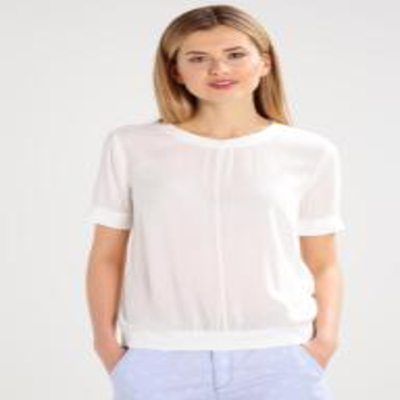

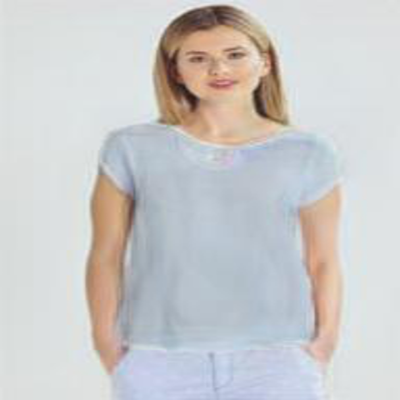

-----------------------------------------------------------------------

SSIM Score of image 15 : 0.9179539084434509 


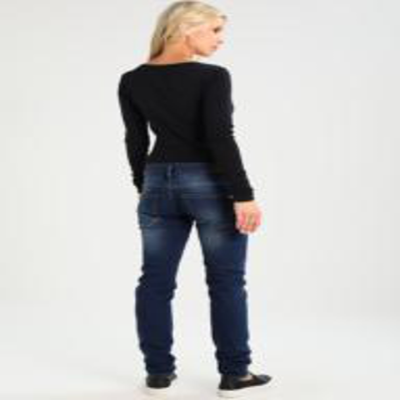

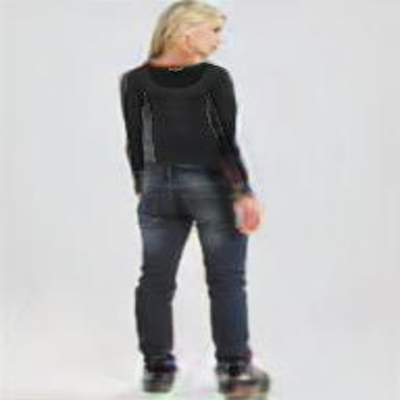

-----------------------------------------------------------------------

SSIM Score of image 16 : 0.9174042344093323 


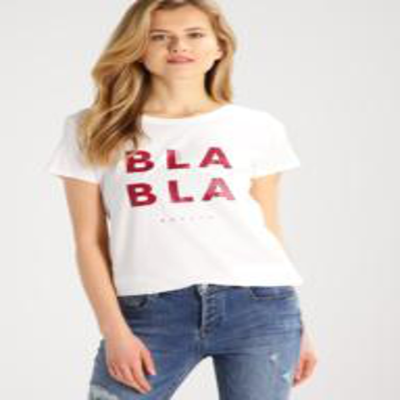

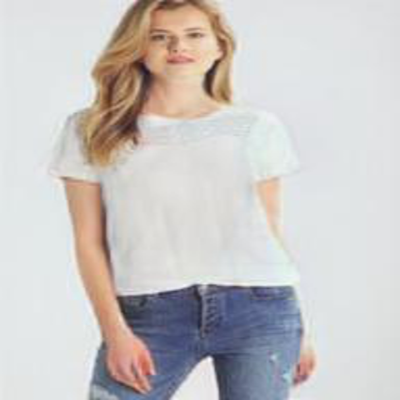

-----------------------------------------------------------------------

SSIM Score of image 17 : 0.9169443249702454 


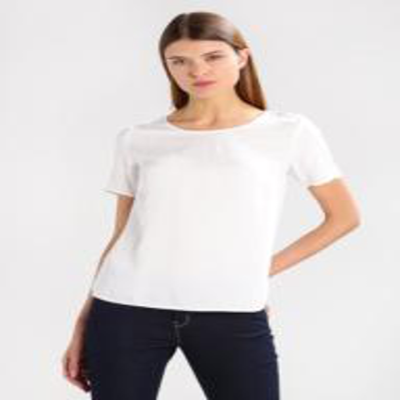

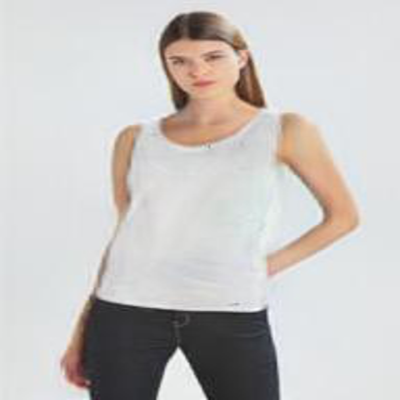

-----------------------------------------------------------------------

SSIM Score of image 18 : 0.9160367250442505 


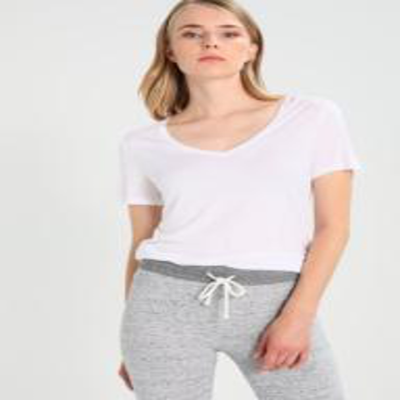

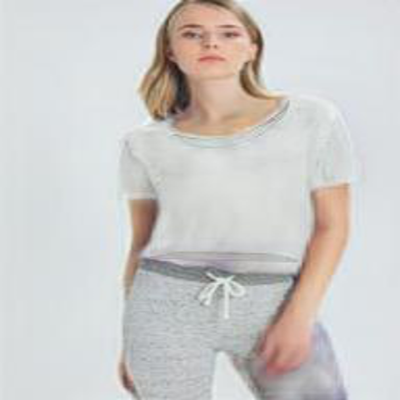

-----------------------------------------------------------------------

SSIM Score of image 19 : 0.9157652258872986 


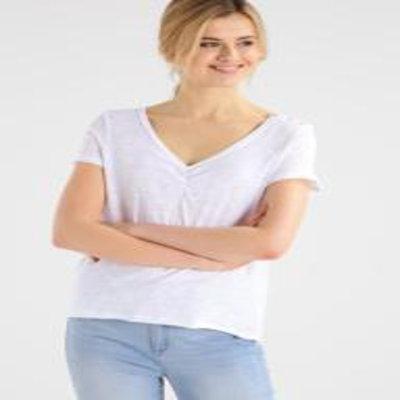

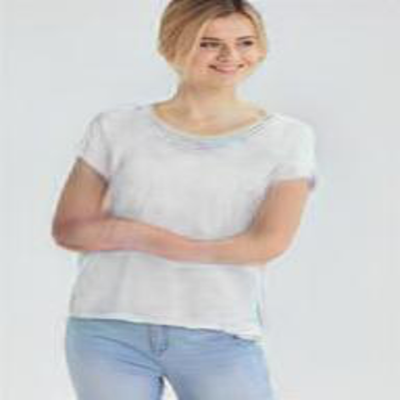

-----------------------------------------------------------------------

SSIM Score of image 20 : 0.9153259992599487 


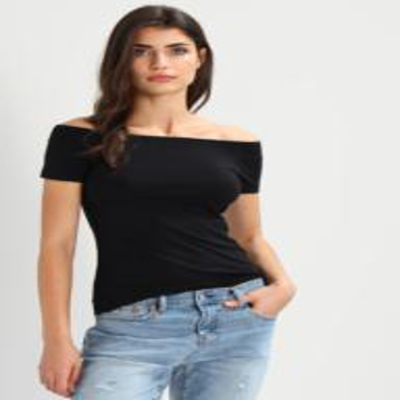

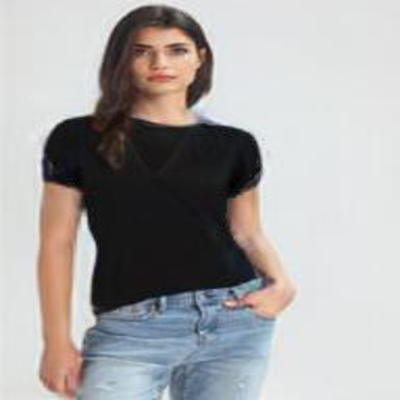

-----------------------------------------------------------------------



 Average SSIM Score : 0.8599972219867561 


In [ ]:
sorted_x = sorted(lst.items(), key=lambda lst: lst[1])
sorted_x.reverse()
sum ,avg,avgRes , n = 0.0 ,0 , 0 , 0
for val in sorted_x:
  sum = sum + val[1]
  n = n+1 
  if n <=20:
    if n==1: 
      print(f'Highest SSIM Score : {val[1]}')
      print('SSIM Score of Top 20 images')
    print(f'SSIM Score of image {n} : {val[1]} ')
    display_imgs(load_images(files[val[0]][0]))
    display_imgs(load_images(files[val[0]][1]))
    print('-----------------------------------------------------------------------')
    print()
  avg = sum / n
  if avg>= 0.80 and avg <= 0.86 and avgRes==0:
    avgRes = avg


print(f'\n\n Average SSIM Score : {avgRes} ') 

In [ ]:
print(sorted_x)

[(434, array(0.9344336, dtype=float32)), (1048, array(0.9340343, dtype=float32)), (1008, array(0.93302834, dtype=float32)), (475, array(0.93063897, dtype=float32)), (1756, array(0.92953706, dtype=float32)), (1397, array(0.92765164, dtype=float32)), (1019, array(0.92622286, dtype=float32)), (84, array(0.92551506, dtype=float32)), (105, array(0.92309844, dtype=float32)), (1516, array(0.9223947, dtype=float32)), (942, array(0.9212684, dtype=float32)), (1038, array(0.9208174, dtype=float32)), (655, array(0.92055136, dtype=float32)), (1695, array(0.92029285, dtype=float32)), (847, array(0.9179539, dtype=float32)), (1596, array(0.91740423, dtype=float32)), (1033, array(0.9169443, dtype=float32)), (621, array(0.9160367, dtype=float32)), (184, array(0.9157652, dtype=float32)), (636, array(0.915326, dtype=float32)), (1021, array(0.91510737, dtype=float32)), (951, array(0.91370803, dtype=float32)), (1809, array(0.912928, dtype=float32)), (1821, array(0.9123022, dtype=float32)), (823, array(0.912